<a href="https://colab.research.google.com/github/singhjasdeep13/csci166project/blob/main/Project_LunarLander_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

**LunarLander v3 - OpenAI Gymnasium Library**

v2 failed (deprecated), v3 was successful.

I used ChatGPT to help set up, resolve issues, and optimize the small details in this code.

The goal of this domain problem is to safely land a spacecraft in a designated landing zone on the moon. The spacecraft is able to maneuver using three engines: main for balancing uplift along with left and right engines to adjust rotation and tilt. In order to land successfully, the model must also balance its trajectory to the landing zone.

**Key Features of the Environment**

State Space: The state space consists of 8 continuous variables that describe the environment.
```
x - horizontal position of the lander.
y - vertical position of the lander.
vx - horizontal velocity of the lander.
vy - vertical velocity of the lander.
angle - the orientation of the lander (rotation).
angular velocity - the rate of change of the angle.
left leg contact - if the left leg is in contact with the ground
(0 = no contact, 1 = contact).
right leg contact - if the right leg is in contact with the ground
(0 = no contact, 1 = contact).
```


Action Space: The action space consists of 4 discrete actions.
```
0: No action.
1: Fire the main engine.
2: Fire the left engine.
3: Fire the right engine.
```

Reward Structure:

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

An episode is considered a solution if it scores at least 200 points.
Goal: The goal of the LunarLander-v2 environment is to control the spacecraft to land it safely in a predefined landing zone by avoiding crashes and managing the orientation and velocity.


# Install dependencies and import required libraries

To run LunarLander, swig and gymnasium are required with a few options.

The libraries being imported are required to apply reinforcement learning.

In [ ]:
!pip install gymnasium --quiet
#!pip install gymnasium[atari] --quiet
!apt-get install -y swig --quiet
!pip install gymnasium[box2d] --quiet

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

# Create model architecture

Using PyTorch. The configuration of the Neural Network is three fully-connected layers with two of the layers consisting of 64 neurons each.

Input = (state) which is the environment
-> apply activation function 'relu' to output x
-> Then passes the output x from the first layer through the second fully-connected layer
-> apply activation function again to the output of the second layer (x)
-> Then passes the output x from the second layer through to the third layer
-> final output layer produces Q-value for each action that represent the expected reward
-> Output = (action)

```
state_size: dimension of each state
action_size: dimension of each action
seed: random seed for reproduceability (13 is arbitrary)
```

In [ ]:
class DQNetwork(nn.Module):
  def __init__(self, state_size, action_size, seed=13):
    super(DQNetwork, self).__init__()
    self.seed=torch.manual_seed(seed)
    self.fc1=nn.Linear(state_size,64)
    self.fc2=nn.Linear(64,64)
    self.fc3=nn.Linear(64,action_size)

  def forward(self,state):
    x=self.fc1(state)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    return self.fc3(x)


# Set up the environment and train the AI model

In [ ]:
env=gym.make("LunarLander-v3")
state_shape=env.observation_space.shape
state_size=env.observation_space.shape[0]
number_action=env.action_space.n
print('State Shape:',state_shape)
print('State Size:',state_size)
print('Number of Actions:',number_action)

State Shape: (8,)
State Size: 8
Number of Actions: 4


### Define hyperparameters

Adjusting these hyperparameters changes the outcome drastically, along with the epsilon values located in the agent class. After much experimentation, I found that these values provide good results (approximately 500-700 episodes for successful landing).

In [ ]:
learning_rate=0.0005          # low learning rate for gradient descent
minibatch_size=100            # how many experiences the agent uses to update nn
discount_factor=0.995         # future reward
replay_buffer_size=100000     # how much experience the agent can store
interpolation_parameter=0.001 # controls how quickly the parameters are updated

### Experience replay

In [ ]:
class ReplayMemory(object):
  def __init__(self,capacity):
    self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.capacity=capacity
    self.memory=[]

  def push(self,event):
    self.memory.append(event)
    if len(self.memory)>self.capacity:
      del self.memory[0]

  def sample(self,batch_size):
    experiences=random.sample(self.memory,k=batch_size)
    states=torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    actions=torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards=torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states=torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones=torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states,next_states,actions,rewards,dones

### DQN Class for agent

In [ ]:
class Agent():
  #local_dqnetwork--> selects the action
  #target_dqnetwork --> calculate target queue values in the local network
  #double queue network stablizes the learning process
  def __init__(self,state_size,action_size):
    self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size=state_size
    self.action_size=action_size
    self.local_qnetwork=DQNetwork(state_size,action_size).to(self.device)
    self.target_qnetwork=DQNetwork(state_size,action_size).to(self.device)
    self.optimizer=optim.Adam(self.local_qnetwork.parameters(),lr=learning_rate)
    self.memory=ReplayMemory(replay_buffer_size)
    self.t_step=0

  def step(self,state,action,reward,next_state,done):
    self.memory.push((state,action,reward,next_state,done))
    self.t_step=(self.t_step + 1) % 4
    if self.t_step==0:
      if len(self.memory.memory)>minibatch_size:
        experiences=self.memory.sample(100)
        self.learn(experiences,discount_factor)

  #act() --> choose action based on action policy
  def act(self,state,epsilon=0.):
    state=torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values=self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random()>epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  #learn() --> agent learns from the replay memory
  def learn(self,experiences,discount_factor):
    states,next_states,actions,rewards,dones=experiences
    next_q_targets=self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets=rewards + (discount_factor*next_q_targets*(1-dones))
    q_expected=self.local_qnetwork(states).gather(1,actions)
    loss=F.mse_loss(q_expected,q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork,self.target_qnetwork,interpolation_parameter)

  #soft_update() --> update target_qnetwork parameters by blending them with local_qnetwork (prevent abrupt changes which could destablize the training)
  def soft_update(self,local_model,target_model,interpolation_parameter):
    for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
      target_param.data.copy_(interpolation_parameter*local_param.data+(1.0-interpolation_parameter)*target_param.data)

### Initialize and train the DQN agent

In [ ]:
agent = Agent(state_size,number_action)

Epsilon is also a hyperparameter, adjusting its values dictates the agent's desire to explore versus receiving the best rewards. Based on the Epsilon-Greedy Strategy, the agent starts off wanting to explore (1.0) and this value decays at a fixed rate of 0.995 with each episode but will not go below 0.01, meaning the agent will explore less over time and make more optimal decisions based on previous experiences.

I experimented with all of these variables and concluded these values to be optimal.

In [ ]:
number_episodes=1000
maximum_number_timesteps_per_episode=1000
epsilon_starting_value=1.0
epsilon_ending_value=0.01
epsilon_decay_value=0.995
epsilon=epsilon_starting_value
scores_on_100_episodes=deque(maxlen=100)
scores=[]

for episode in range(1,number_episodes+1):
  state,_=env.reset()
  score=0
  for t in range(maximum_number_timesteps_per_episode):
    action=agent.act(state,epsilon)
    next_state,reward,done,_,_=env.step(action)
    agent.step(state,action,reward,next_state,done)
    state=next_state
    score+=reward
    if done:
      break;
  scores.append(score)
  scores_on_100_episodes.append(score)
  epsilon=max(epsilon_ending_value,epsilon_decay_value*epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)),end="")
  if episode%100==0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes)>=200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(),'checkpoint.pth')
    break;

Episode 100	Average Score: -153.98
Episode 200	Average Score: -83.79
Episode 300	Average Score: -27.98
Episode 400	Average Score: 18.10
Episode 500	Average Score: 105.00
Episode 600	Average Score: 197.47
Episode 603	Average Score: 200.05
Environment solved in 603 episodes!	Average Score: 200.05


# Plot the results (score per episode)

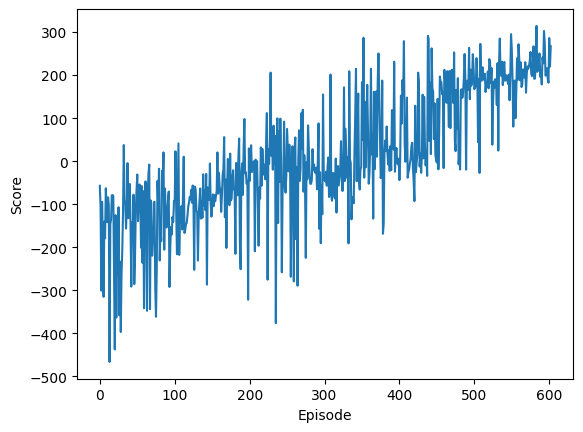

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

# Animate the results

In [ ]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()